In [1]:
!mkdir gazeset
#!gdown https://drive.google.com/uc?id=1wqTA4gutC-L4h8TcMMQO_3jJYBL15-h3
!unzip -qq "/content/drive/MyDrive/data/UnityEye/UnityEye Archive.zip" -d gazeset

!mkdir gazeset_50
!unzip -qq "/content/drive/MyDrive/data/UnityEye/imgs50.zip" -d gazeset_50

In [2]:
!for FILENAME in /content/gazeset_50/imgs/*; do mv $FILENAME /content/gazeset/imgs/50g_FILENAME; done 

In [3]:
!ls /content/gazeset_50/imgs/

In [ ]:
!pip install fairseq==0.10.2

#!git clone https://github.com/pytorch/fairseq
#%%capture
#!git clone https://github.com/idiap/fast-transformers.git
#%cd fast-transformers
#!python setup.py install
#!pip install --user pytorch-fast-transformers
#!pip3 install https://download.pytorch.org/whl/cu100/torchvision-0.3.0-cp36-cp36m-linux_x86_64.whl
#!pip install functools
#!pip install thop

!pip install local-attention==1.2.2
!pip install axial-positional-embedding==0.2.1

!pip install adabelief-pytorch==0.2.0
!pip install ranger-adabelief==0.1.0

!pip install pytorch-lightning

!pip install comet-ml

!pip install vit-pytorch
!pip install torchaudio

In [1]:
from comet_ml import Experiment
from pytorch_lightning.loggers import CometLogger
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint


import torch.nn as nn

import sys
import os

"""
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
"""

import cv2
import numpy as np
from matplotlib import pyplot as plt

from scipy.spatial.transform import Rotation as R

from __future__ import print_function, division
from typing import Optional

import torch
from torch.utils.data import Dataset, DataLoader
import glob
import json

from dependency import *

from sublocks import LinearAttention, MultiheadAttentionRPR, Dynamic_module, AttentionLayer, Swish, swish_f, Mish, mish_f
from sublocks import PositionalEncoding, AxialPositionalEncoding, PositionwiseFeedForward, PositionwiseFeedForward_conv, SelfAttention_local, GLUblock, GLUblock_no_wn
import copy
from einops import rearrange


from adabelief_pytorch import AdaBelief
from ranger_adabelief import RangerAdaBelief


def generate_relative_positions_matrix(length, max_relative_positions,
                                       cache=False):
    """Generate the clipped relative positions matrix
       for a given length and maximum relative positions"""
    if cache:
        distance_mat = torch.arange(-length+1, 1, 1).unsqueeze(0)
    else:
        range_vec = torch.arange(length)
        range_mat = range_vec.unsqueeze(-1).expand(-1, length).transpose(0, 1)
        distance_mat = range_mat - range_mat.transpose(0, 1)
    distance_mat_clipped = torch.clamp(distance_mat,
                                       min=-max_relative_positions,
                                       max=max_relative_positions)
    # Shift values to be >= 0
    final_mat = distance_mat_clipped + max_relative_positions
    return final_mat

In [2]:
def pitchyaw_to_vector(pitchyaws):
    r"""Convert given yaw (:math:`\theta`) and pitch (:math:`\phi`) angles to unit gaze vectors.
    Args:
        pitchyaws (:obj:`numpy.array`): yaw and pitch angles :math:`(n\times 2)` in radians.
    Returns:
        :obj:`numpy.array` of shape :math:`(n\times 3)` with 3D vectors per row.
    """
    n = pitchyaws.shape[0]
    sin = np.sin(pitchyaws)
    cos = np.cos(pitchyaws)
    out = np.empty((n, 3))
    out[:, 0] = np.multiply(cos[:, 0], sin[:, 1])
    out[:, 1] = sin[:, 0]
    out[:, 2] = np.multiply(cos[:, 0], cos[:, 1])
    return out


def vector_to_pitchyaw(vectors):
    r"""Convert given gaze vectors to yaw (:math:`\theta`) and pitch (:math:`\phi`) angles.
    Args:
        vectors (:obj:`numpy.array`): gaze vectors in 3D :math:`(n\times 3)`.
    Returns:
        :obj:`numpy.array` of shape :math:`(n\times 2)` with values in radians.
    """
    n = vectors.shape[0]
    out = np.empty((n, 2))
    vectors = np.divide(vectors, np.linalg.norm(vectors, axis=1).reshape(n, 1))
    out[:, 0] = np.arcsin(vectors[:, 1])  # theta
    out[:, 1] = np.arctan2(vectors[:, 0], vectors[:, 2])  # phi
    return out

radians_to_degrees = 180.0 / np.pi


def angular_error(a, b):
    """Calculate angular error (via cosine similarity)."""
    a = pitchyaw_to_vector(a) if a.shape[1] == 2 else a
    b = pitchyaw_to_vector(b) if b.shape[1] == 2 else b

    ab = np.sum(np.multiply(a, b), axis=1)
    a_norm = np.linalg.norm(a, axis=1)
    b_norm = np.linalg.norm(b, axis=1)

    # Avoid zero-values (to avoid NaNs)
    a_norm = np.clip(a_norm, a_min=1e-7, a_max=None)
    b_norm = np.clip(b_norm, a_min=1e-7, a_max=None)

    similarity = np.divide(ab, np.multiply(a_norm, b_norm))

    return np.arccos(similarity) * radians_to_degrees


def mean_angular_error(a, b):
    """Calculate mean angular error (via cosine similarity)."""
    return np.mean(angular_error(a, b))


def draw_gaze(image_in, eye_pos, pitchyaw, length=40.0, thickness=2, color=(0, 0, 255)):
    """Draw gaze angle on given image with a given eye positions."""
    image_out = image_in
    if len(image_out.shape) == 2 or image_out.shape[2] == 1:
        image_out = cv2.cvtColor(image_out, cv2.COLOR_GRAY2BGR)
    dx = -length * np.sin(pitchyaw[1])
    dy = length * np.sin(pitchyaw[0])
    cv2.arrowedLine(image_out, tuple(np.round(eye_pos).astype(np.int32)),
                   tuple(np.round([eye_pos[0] + dx, eye_pos[1] + dy]).astype(int)), color,
                   thickness, cv2.LINE_AA, tipLength=0.2)
    return image_out

In [45]:
def preprocess_unityeyes_image(img, json_data):
    ow = 160
    oh = 96
    # Prepare to segment eye image
    ih, iw = img.shape[:2]
    ih_2, iw_2 = ih/2.0, iw/2.0

    heatmap_w = int(ow/2)
    heatmap_h = int(oh/2)

    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    def process_coords(coords_list):
        coords = [eval(l) for l in coords_list]
        return np.array([(x, ih-y, z) for (x, y, z) in coords])
    
    interior_landmarks = process_coords(json_data['interior_margin_2d'])
    caruncle_landmarks = process_coords(json_data['caruncle_2d'])
    iris_landmarks = process_coords(json_data['iris_2d'])

    left_corner = np.mean(caruncle_landmarks[:, :2], axis=0)
    right_corner = interior_landmarks[8, :2]
    eye_width = 1.5 * abs(left_corner[0] - right_corner[0])
    eye_middle = np.mean([np.amin(interior_landmarks[:, :2], axis=0),
                          np.amax(interior_landmarks[:, :2], axis=0)], axis=0)

    # Normalize to eye width.
    scale = ow/eye_width

    translate = np.asmatrix(np.eye(3))
    translate[0, 2] = -eye_middle[0] * scale
    translate[1, 2] = -eye_middle[1] * scale

    rand_x = np.random.uniform(low=-10, high=10)
    rand_y = np.random.uniform(low=-10, high=10)
    recenter = np.asmatrix(np.eye(3))
    recenter[0, 2] = ow/2 + rand_x
    recenter[1, 2] = oh/2 + rand_y

    scale_mat = np.asmatrix(np.eye(3))
    scale_mat[0, 0] = scale
    scale_mat[1, 1] = scale

    angle = 0 #np.random.normal(0, 1) * 20 * np.pi/180
    rotation = R.from_rotvec([0, 0, angle]).as_matrix()

    transform = recenter * rotation * translate * scale_mat
    transform_inv = np.linalg.inv(transform)
    
    # Apply transforms
    eye = cv2.warpAffine(img, transform[:2], (ow, oh))

    rand_blur = np.random.uniform(low=0, high=20)
    eye = cv2.GaussianBlur(eye, (5, 5), rand_blur)

    # Normalize eye image
    eye = cv2.equalizeHist(eye)
    eye = eye.astype(np.float32)
    eye = eye / 255.0

    # Gaze
    # Convert look vector to gaze direction in polar angles
    look_vec = np.array(eval(json_data['eye_details']['look_vec']))[:3].reshape((1, 3))
    #look_vec = np.matmul(look_vec, rotation.T)

    gaze = vector_to_pitchyaw(-look_vec).flatten()
    gaze = gaze.astype(np.float32)

    iris_center = np.mean(iris_landmarks[:, :2], axis=0)

    landmarks = np.concatenate([interior_landmarks[:, :2],  # 8
                                iris_landmarks[::2, :2],  # 8
                                iris_center.reshape((1, 2)),
                                [[iw_2, ih_2]],  # Eyeball center
                                ])  # 18 in total

    landmarks = np.asmatrix(np.pad(landmarks, ((0, 0), (0, 1)), 'constant', constant_values=1))
    landmarks = np.asarray(landmarks * transform[:2].T) * np.array([heatmap_w/ow, heatmap_h/oh])
    landmarks = landmarks.astype(np.float32)

    # Swap columns so that landmarks are in (y, x), not (x, y)
    # This is because the network outputs landmarks as (y, x) values.
    temp = np.zeros((34, 2), dtype=np.float32)
    temp[:, 0] = landmarks[:, 1]
    temp[:, 1] = landmarks[:, 0]
    landmarks = temp

    heatmaps = get_heatmaps(w=heatmap_w, h=heatmap_h, landmarks=landmarks)

    assert heatmaps.shape == (34, heatmap_h, heatmap_w)

    return {
        'img': eye,
        'transform': np.asarray(transform),
        'transform_inv': np.asarray(transform_inv),
        'eye_middle': np.asarray(eye_middle),
        'heatmaps': np.asarray(heatmaps),
        'landmarks': np.asarray(landmarks),
        'gaze': np.asarray(gaze)
    }


def gaussian_2d(w, h, cx, cy, sigma=1.0):
    """Generate heatmap with single 2D gaussian."""
    xs, ys = np.meshgrid(
        np.linspace(0, w - 1, w, dtype=np.float32),
        np.linspace(0, h - 1, h, dtype=np.float32)
    )

    assert xs.shape == (h, w)
    alpha = -0.5 / (sigma ** 2)
    heatmap = np.exp(alpha * ((xs - cx) ** 2 + (ys - cy) ** 2))
    return heatmap


def get_heatmaps(w, h, landmarks):
    heatmaps = []
    for (y, x) in landmarks:
        heatmaps.append(gaussian_2d(w, h, cx=x, cy=y, sigma=2.0))
    return np.array(heatmaps)

In [46]:
class UnityEyesDataset(Dataset):

    def __init__(self, img_dir: Optional[str] = None):

        if img_dir is None:
            img_dir = os.path.join(os.path.dirname(__file__), 'UnityEyes/imgs')

        self.img_paths = glob.glob(os.path.join(img_dir, '*.jpg'))
        self.img_paths = sorted(self.img_paths, key=lambda x: int(os.path.splitext(os.path.basename(x))[0]))
        self.json_paths = []
        for img_path in self.img_paths:
            idx = os.path.splitext(os.path.basename(img_path))[0]
            self.json_paths.append(os.path.join(img_dir, f'{idx}.json'))

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        full_img = cv2.imread(self.img_paths[idx])
        with open(self.json_paths[idx]) as f:
            json_data = json.load(f)

        eye_sample = preprocess_unityeyes_image(full_img, json_data)
        sample = {'full_img': full_img, 'json_data': json_data }
        sample.update(eye_sample)
        return sample

In [47]:
def softargmax2d(input, beta=100, dtype=torch.float32):
    *_, h, w = input.shape

    input = input.reshape(*_, h * w)
    input = nn.functional.softmax(beta * input, dim=-1)

    indices_c, indices_r = np.meshgrid(
        np.linspace(0, 1, w),
        np.linspace(0, 1, h),
        indexing='xy'
    )

    indices_r = torch.tensor(np.reshape(indices_r, (-1, h * w)))
    indices_c = torch.tensor(np.reshape(indices_c, (-1, h * w)))

    device = input.get_device()
    if device >= 0:
        indices_r = indices_r.to(device)
        indices_c = indices_c.to(device)

    result_r = torch.sum((h - 1) * input * indices_r, dim=-1)
    result_c = torch.sum((w - 1) * input * indices_c, dim=-1)

    result = torch.stack([result_r, result_c], dim=-1)

    return result.type(dtype)


def softargmax1d(input, beta=100):
    *_, n = input.shape
    input = nn.functional.softmax(beta * input, dim=-1)
    indices = torch.linspace(0, 1, n)
    result = torch.sum((n - 1) * input * indices, dim=-1)
    return result

In [48]:
class Main_Block(nn.Module):
  def __init__(self, type_dict):
    super(Main_Block, self).__init__()
    print("used type is: ", type_dict)
    choose_module = {
      "dynamic": Dynamic_module(type_module = type_dict["type_module"], 
                                   d = type_dict["d"], kernel_size = type_dict["kernel_size_dynamic"], 
                                   num_heads = type_dict["num_heads"], dropout = type_dict["dropout"]),
                     
      "light": Dynamic_module(type_module = type_dict["type_module"], 
                                   d = type_dict["d"], kernel_size = type_dict["kernel_size_dynamic"], 
                                   num_heads = type_dict["num_heads"], dropout = type_dict["dropout"]),

      "att" : nn.MultiheadAttention(type_dict["d"], type_dict["num_heads"], type_dict["dropout"]),
      "gcn" : GLUblock(type_dict["k_kernel_glu"], type_dict["d"], type_dict["d"], type_dict["downbot_glu"]),
      "gcn_no_wn" : GLUblock_no_wn(type_dict["k_kernel_glu"], type_dict["d"], type_dict["d"], type_dict["downbot_glu"]),
      "linear" : AttentionLayer(LinearAttention(), type_dict["d"], type_dict["num_heads"]),
      "rpr": MultiheadAttentionRPR(type_dict["d"], type_dict["num_heads"], type_dict["max_relative_positions_rpr"], type_dict["dropout"]),
      "local_sa": SelfAttention_local(type_dict["d"], type_dict["num_heads"], 
                                n_local_attn_heads = type_dict["n_local_attn_heads"], dropout = type_dict["dropout"],
                                local_attn_window_size = type_dict["local_attn_window_size"]),
    }
    self.type_module = type_dict["type_module"]
    self.block = choose_module[type_dict["type_module"]]
  def forward(self, x):
    if self.type_module in ["linear", "dynamic", "light", "local_sa"]:
      x = self.block(x)
    elif self.type_module == "gcn":
      x.unsqueeze_(-1)
      x = x.transpose(1,2)#.contiguous()
      x = self.block(x)
      x = x.transpose(1,2)#.contiguous()
      x.squeeze_(-1)
    elif self.type_module == "att":
      x = x.transpose(0,1)#.contiguous()
      x, _= self.block(x, x, x)
      x = x.transpose(0,1)#.contiguous()
    elif self.type_module == "rpr":
      x = x.transpose(0,1)#.contiguous()
      x, _ = self.block(x)
      x = x.transpose(0,1)#.contiguous()
    return x

In [49]:
class Swish(nn.Module):
    def __init__(self):
        super(Swish, self).__init__()
    def forward(self, x):
        return x * torch.sigmoid(x)

def swish_f(x):
    return x * torch.sigmoid(x)

def Mish_F(x):
    return x * torch.tanh(F.softplus(x))

class Mish(nn.Module):
    def __init__(self):
        super(Mish, self).__init__()
    def forward(self, x):
        return x * torch.tanh(F.softplus(x))


def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])


#https://github.com/xcmyz/FastSpeech/blob/896fe0276840267ba9565f4d620673695f7eef06/transformer/SubLayers.py#L72
class PositionwiseFeedForward_conv(nn.Module):
    ''' A two-feed-forward-layer module '''

    def __init__(self, d_in, d_hid = None, glu = False, activation = F.relu, dropout=0.1):
        super().__init__()
        print("print conv Feed Forward with glu: ", glu)
        if d_hid is None:
          d_hid = d_in * 4
        d_hid_ = d_hid * (2 if glu else 1)
        self.glu = glu
        # Use Conv1D
        # position-wise
        self.w_1 = nn.Conv1d(
            d_in, d_hid_, kernel_size=9, padding=4)
        # position-wise
        self.w_2 = nn.Conv1d(
            d_hid, d_in, kernel_size=3, padding=1)

        self.activation = activation

        self.layer_norm = nn.LayerNorm(d_in)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        #residual = x
        output = x.transpose(1, 2)
        if not self.glu:
          output = self.activation(self.w_1(output))
        else:
          output, gating = self.w_1(output).transpose(-1, -2).chunk(2, dim=-1)
          output = self.activation(output) * gating
          output = output.transpose(-1, -2)
  
        output = self.w_2(output)
        output = output.transpose(1, 2)
        output = self.dropout(output)
        output = self.layer_norm(output + x) #residual

        return output



class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_hid = None, activation = F.relu, glu = False, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        print("print positionwise Feed Forward with glu: ", glu)
        if d_hid is None:
          d_hid = d_model * 4
        d_hid_ = d_hid * (2 if glu else 1)

        self.glu = glu

        self.w_1 = nn.Linear(d_model, d_hid_)
        self.activation = activation
        self.w_2 = nn.Linear(d_hid, d_model)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(d_model)

    def forward(self, x):
        
        output = x
        if not self.glu:
          output = self.activation(self.w_1(output))
        else:
          output, gating = self.w_1(output).chunk(2, dim=-1)
          output = self.activation(output) * gating
  
        output = self.w_2(output)

        output = self.dropout(output)
        output = self.layer_norm(output + x) #residual

        return output



class Block_Updated(nn.Module):
    def __init__(self, re_dict):
        super(Block_Updated, self).__init__()
        print("Block_Updated used")
        model_dict = re_dict["model_dict"]

        #self.dropout = nn.Dropout(model_dict["dropout_block"])

        self.att = Main_Block(re_dict["main_block"])
        self.layer_norm = nn.LayerNorm(model_dict["d"])

        d = model_dict["d"]
        activation = Mish_F
        glu = model_dict["ff_glu"]
        ff_dropout = model_dict["ff_dropout"]

        if model_dict["ff_type"] == "conv":
            self.ff = PositionwiseFeedForward_conv(d, activation = activation, glu = glu, dropout = ff_dropout)
        elif model_dict["ff_type"] == "fc":
            self.ff = PositionwiseFeedForward(d, activation = activation, glu = glu, dropout = ff_dropout)
    
    def forward(self, x):
        
        
        residual = x
        x = self.att(x)
        #output = self.dropout(output)
        x = self.layer_norm(x + residual) #residual
        x = self.ff(x)
        
        return x


class Encoder_wrapper(nn.Module):

  def __init__(self, re_dict):
    super(Encoder_wrapper, self).__init__()

    self.model_dict = re_dict["model_dict"]
    layer = Block_Updated(re_dict)
    self.layers = clones(layer, self.model_dict["blocks_number"])


    self.norm_in_wrapper = False
    if self.model_dict["norm_in_wrapper"]:
      self.norm_in_wrapper = True
      self.norm = nn.LayerNorm(self.model_dict["d"])
    
    if self.model_dict["weight_init"]:
      self.weight_init()

  def weight_init(self):
    for p in self.parameters():
      if p.dim() > 1:
        nn.init.xavier_uniform_(p)
    
  def forward(self, x):
      
      for layer in self.layers:
          x = layer(x)
      if self.norm_in_wrapper:
          x = self.norm(x)
      
      return x

In [50]:
# https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py

def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
  def __init__(self, inn, out):
    super(BasicBlock, self).__init__()
    norm_layer = nn.BatchNorm2d

    self.conv1 = conv3x3(inn, out)
    self.bn1 = norm_layer(out)
    self.relu = nn.ReLU(inplace=True)
    self.conv2 = conv3x3(out, out)
    self.bn2 = norm_layer(out)

  def forward(self, x):
      identity = torch.mean(x, dim = 1)[:, None]

      out = self.conv1(x)
      out = self.bn1(out)
      out = self.relu(out)

      out = self.conv2(out)
      out = self.bn2(out)

      out += identity
      
      out = self.relu(out)

      return out


class HeatMapExctract(nn.Module):
  def __init__(self, in_channels):
    super(HeatMapExctract, self).__init__()
    self.block1 = BasicBlock(in_channels, 6)
    self.block2 = BasicBlock(6, 12)
    self.block3 = BasicBlock(12, 24)
    self.block4 = BasicBlock(24, 34)

    self.downsample = nn.AvgPool2d(2, 2)

  def forward(self, x):
      x = self.block1(x)
      x = self.block2(x)
      x = self.block3(x)
      x = self.block4(x)

      x = self.downsample(x)

      return x

In [51]:
class Model_dl(nn.Module):
    def __init__(self, hparams):
        super(Model_dl, self).__init__()
        
        self.hparams = hparams
        self.vit_params = self.hparams["vit_params"]
        
        if self.vit_params["grayscale"]:
            self.channels = 1
        else:
            self.channels = 3
        
        self.im_size, patch_size, d_model_emb = self.vit_params["im_size"], self.vit_params["patch_size"], self.vit_params["d_model_emb"]
        self.im_size_h = self.vit_params["im_size_h"]
        self.patch_size = patch_size
 
        n_patch = (int(self.im_size/patch_size)) * (int(self.im_size_h/patch_size))

        self.one_patch_dim = int(self.channels * (patch_size)**2)
        
        self.positional_embedding = nn.Parameter(torch.randn(1, n_patch + 1, d_model_emb))
        
        self.patch_embedding = nn.Linear(self.one_patch_dim, d_model_emb)
        self.dropout = nn.Dropout(self.vit_params["dropout"])
        self.zero_class_token = nn.Parameter(torch.randn(1, 1, d_model_emb))
        
        self.encoder = Encoder_wrapper(self.hparams)

        self.feature_extcractor = nn.Identity()

        self.gaze_mlp = nn.Sequential(
                                       nn.Linear(d_model_emb, d_model_emb),
                                       Mish(),
                                       nn.Dropout(self.vit_params["mlp_drop"]),
                                       nn.Linear(d_model_emb, self.vit_params["gaze_size"]),
                                      )

        self.heatmap_ex = HeatMapExctract(self.channels)
        
    def forward(self, image):  # 1 1 (96) (160) - >  1 (60: 6 * 10) (256: 16 * 16)
        x = rearrange(image, 'b c (h p) (w pd) -> b (h w) (p pd c)', p = self.patch_size, pd = self.patch_size)
        x = self.patch_embedding(x)
        x = self.dropout(x)

        b, n, d = x.shape

        zero_class_token = torch.repeat_interleave(self.zero_class_token, repeats = b, dim=0)
        x = torch.cat((zero_class_token, x), dim=1)

        x = x + self.positional_embedding
        x = self.encoder(x)

        gaze = self.feature_extcractor(x[:, 0])
        gaze = self.gaze_mlp(gaze)

        x = rearrange(x[:, 1:], 'b (h w) (p pd c) -> b c (h p) (w pd)', h = int(self.im_size_h/self.patch_size),  p = self.patch_size, pd = self.patch_size, )   # c = self.channels, p = self.patch_size, h = self.im_size_h, w = self.im_size
        heatmaps = self.heatmap_ex(x)

        landmarks_out = softargmax2d(heatmaps)

        return gaze, heatmaps, landmarks_out

In [52]:
class Dataset_Unity(pl.LightningDataModule):
    def __init__(self, conf, *args, **kwargs): #*args, **kwargs hparams, steps_per_epoch
      super().__init__()
      self.hparams = conf
      
    def prepare_data(self):
      print("can add download here")
    
    def setup(self):
      dataset = UnityEyesDataset(self.hparams["path_data"])
      
      N = len(dataset)
      print(N)
      VN = 160
      TN = N - VN
      self.dataset_train, self.dataset_val = torch.utils.data.random_split(dataset, (TN, VN))
      self.test = None

    def train_dataloader(self):
      data_train = DataLoader(self.dataset_train, batch_size=self.hparams["batch_size"], num_workers=self.hparams["num_workers"], 
                              shuffle=self.hparams["dataloader_shuffle"], 
                              )
      return data_train

    def val_dataloader(self):
      val = DataLoader(self.dataset_val, batch_size=self.hparams["batch_size"], num_workers=self.hparams["num_workers"], 
                              shuffle=False, 
                              )
      return val

    def test_dataloader(self):
      test = self.dataset_test
      return test

In [53]:
class HeatmapLoss(torch.nn.Module):
    def __init__(self):
        super(HeatmapLoss, self).__init__()

    def forward(self, pred, gt):
        loss = ((pred - gt)**2)
        loss = torch.mean(loss, dim=(1, 2, 3))
        return loss


class AngularError(torch.nn.Module):
    def __init__(self):
        super(AngularError, self).__init__()

    def forward(self, gaze_pred, gaze):
        loss = ((gaze_pred - gaze)**2)
        loss = torch.mean(loss, dim=(1, 2, 3))
        return loss

In [58]:
class Re_pl(pl.LightningModule):
    def __init__(self, re_dict, *args, **kwargs): #*args, **kwargs hparams, steps_per_epoch
        super().__init__()
        self.save_hyperparameters(re_dict)
        self.save_hyperparameters()
        #self.hparams = hparams
        self.swa_model = None

        self.network = Model_dl(self.hparams)
        self.learning_params = self.hparams["training"]

        self.heatmapLoss = HeatmapLoss()
        self.landmarks_loss = nn.MSELoss()
        self.gaze_loss = nn.MSELoss()

    def forward(self, x):
      gaze, heatmaps, landmarks_out = self.network(x)
      return gaze, heatmaps, landmarks_out


    def loss_calc(self, combined_hm_preds, heatmaps, landmarks_pred, landmarks, gaze_pred, gaze):

      heatmap_loss = self.heatmapLoss(combined_hm_preds, heatmaps)
      landmarks_loss = self.landmarks_loss(landmarks_pred, landmarks)
      gaze_loss = self.gaze_loss(gaze_pred, gaze) * 10

      return torch.sum(heatmap_loss), landmarks_loss, gaze_loss


    def shared_step(self, batch):
      imgs = batch['img'][:, None]
      heatmaps = batch['heatmaps']
      landmarks = batch['landmarks']
      gaze = batch['gaze']
      gaze_pred, heatmaps_pred, landmarks_out = self(imgs)

      heatmaps_loss, landmarks_loss, gaze_loss = self.loss_calc(
                  heatmaps_pred, heatmaps, landmarks_out, landmarks, gaze_pred, gaze,
                  )
      return heatmaps_loss, landmarks_loss, gaze_loss


    def training_step(self, batch, batch_idx):
      heatmaps_loss, landmarks_loss, gaze_loss = self.shared_step(batch)
      loss = heatmaps_loss + landmarks_loss + gaze_loss
      
      self.log('train_loss_heatmap', heatmaps_loss, on_step=False, on_epoch=True, logger=True)
      self.log('train_loss_landmarks', landmarks_loss, on_step=False, on_epoch=True, logger=True)
      self.log('train_loss_gaze', gaze_loss, on_step=False, on_epoch=True, logger=True)
      
      self.log('train_loss', loss, on_step=True, on_epoch=True, logger=True) # prog_bar=True
      
      return loss


    def validation_step(self, batch, batch_idx):
      heatmaps_loss, landmarks_loss, gaze_loss = self.shared_step(batch)
      loss =  heatmaps_loss + landmarks_loss + gaze_loss
      
      self.log('vall_loss_heatmap', heatmaps_loss, on_step=False, on_epoch=True, logger=True)
      self.log('val_loss_landmarks', landmarks_loss, on_step=False, on_epoch=True, logger=True)
      self.log('val_loss_gaze', gaze_loss, on_step=False, on_epoch=True, logger=True)
      
      self.log('val_loss', loss, on_step=False, on_epoch=True, logger=True) # prog_bar=True
      
      return {'val_loss': loss}

    #copied
    def get_lr_inside(self, optimizer):
        for param_group in optimizer.param_groups:
            return param_group['lr']


    def training_epoch_end(self, outputs):
        self.log('epoch_now', self.current_epoch, on_step=False, on_epoch=True, logger=True)
        (oppp) =  self.optimizers(use_pl_optimizer=True)
        self.log('lr_now', self.get_lr_inside(oppp), on_step=False, on_epoch=True, logger=True)



    def configure_optimizers(self):
        if self.learning_params["optimizer"] == "belief":
            optimizer =  AdaBelief(self.parameters(), lr = self.learning_params["lr"], eps = self.learning_params["eplison_belief"],
                                    weight_decouple = self.learning_params["weight_decouple"], 
                                    weight_decay = self.learning_params["weight_decay"], rectify = self.learning_params["rectify"])
        elif self.learning_params["optimizer"] == "ranger_belief":
            optimizer = RangerAdaBelief(self.parameters(), lr = self.learning_params["lr"], eps = self.learning_params["eplison_belief"],
                                       weight_decouple = self.learning_params["weight_decouple"],  weight_decay = self.learning_params["weight_decay"],)
        elif self.learning_params["optimizer"] == "adam":
            optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_params["lr"])
        elif self.learning_params["optimizer"] == "adamW":
            optimizer = torch.optim.AdamW(self.parameters(), lr=self.learning_params["lr"])        

        if self.learning_params["add_sch"]:
            lr_scheduler = {'scheduler': torch.optim.lr_scheduler.OneCycleLR(optimizer,
	                                                                        max_lr=self.learning_params["lr"],
	                                                                        steps_per_epoch=self.hparams.steps_per_epoch, #int(len(train_loader))
	                                                                        epochs=self.learning_params["epochs"],
	                                                                        anneal_strategy='linear'),
                        'name': 'lr_scheduler_lr',
                        'interval': 'step', # or 'epoch'
                        'frequency': 1,
                        }
            print("sch added")
            return [optimizer], [lr_scheduler]

        return optimizer

In [59]:
dataset_unity = {
    "path_data": "/content/gazeset/imgs/",
    "batch_size": 64,
    "num_workers": 2,
    "dataloader_shuffle": True,
}

ViT_param = {
    "grayscale": True,
    "im_size": 160,
    "im_size_h": 96,
    "patch_size": 16, 
    "d_model_emb": 16*16,
    "dropout": 0.05,
    "mlp_drop": 0.05,
    "gaze_size": 2,

}

main_block_dict_new = { #if some of the params not needed just put random values there
    "type_module" : "att", #light, att, gcn, linear, rpr, dynamic, local_sa
    "d": 16*16,
    "dropout": 0.05,
    "num_heads": 4, #so n_local_attn_heads + global = num_heads
    
    #
    "n_local_attn_heads": 2,
    "local_attn_window_size": 50,
    #
    "kernel_size_dynamic": 30, 
    #
    "k_kernel_glu": 4,
    "downbot_glu": 2,
    #
    "max_relative_positions_rpr": 8,
}


model_dict_new = {
    "d": 16*16,

    "ff_type": "fc", #conv, fc
    "ff_glu": False,
    "ff_dropout": 0.05,

    "dropout_block": 0, # not used
    "blocks_number": 2,

    "norm_in_wrapper": True,
    "weight_init": False,

}


training_unity = {
    "optimizer": "belief", # "belief", "ranger_belief", "adam", adamW
    "lr": 3e-4, #
    "eplison_belief": 1e-16,
    "beta": [0.9, 0.999], # not used
    "weight_decouple": True, 
    "weight_decay": 1e-4,
    "rectify": True,
    #
    "add_sch": False,
    #
    "epochs": 20, #
}


re_dict = {
    "dataset": dataset_unity,
    "main_block": main_block_dict_new,
    "model_dict": model_dict_new,
    "vit_params": ViT_param,
    "training": training_unity,
}

In [60]:
class CheckpointEveryNSteps(pl.Callback):
    """
    Save a checkpoint every N steps, instead of Lightning's default that checkpoints
    based on validation loss.
    """

    def __init__(
        self,
        save_step_frequency,
        prefix="N-Step-Checkpoint",
        use_modelcheckpoint_filename=False,
        pathh = False,
    ):
        """
        Args:
            save_step_frequency: how often to save in steps
            prefix: add a prefix to the name, only used if
                use_modelcheckpoint_filename=False
            use_modelcheckpoint_filename: just use the ModelCheckpoint callback's
                default filename, don't use ours.
        """
        self.save_step_frequency = save_step_frequency
        self.prefix = prefix
        self.use_modelcheckpoint_filename = use_modelcheckpoint_filename
        self.pathh = pathh

    def on_batch_end(self, trainer: pl.Trainer, _):
        """ Check if we should save a checkpoint after every train batch """
        epoch = trainer.current_epoch
        global_step = trainer.global_step
        if global_step % self.save_step_frequency == 0:
            if self.use_modelcheckpoint_filename:
                filename = trainer.checkpoint_callback.filename
            else:
                filename = f"{self.prefix}_{epoch}_{global_step}.ckpt"
            ckpt_path = os.path.join(self.pathh, filename)
            print("we are here!!!")
            trainer.save_checkpoint(ckpt_path)

In [61]:
seed_v = 42
seed_everything(seed_v)

root_dir = "/content/drive/MyDrive/data/weights"
naming = "unity_eye5"
from datetime import datetime

comet_logger = CometLogger(
  save_dir='/content/log/',
    api_key="23CU99n7TeyZdPeegNDlQ5aHf",
    project_name="imageeye",
    workspace="etzelkut",
  # rest_api_key=os.environ["COMET_REST_KEY"], # Optional
  experiment_name = naming, # Optional
)


#
dataset_pl = Dataset_Unity(re_dict["dataset"])
dataset_pl.prepare_data()
dataset_pl.setup()
steps_per_epoch = int(len(dataset_pl.train_dataloader()))
print(steps_per_epoch)

every_epoch = CheckpointEveryNSteps(save_step_frequency = steps_per_epoch, 
                                    use_modelcheckpoint_filename = False, 
                                    pathh=root_dir, prefix=naming+"N-Step-Checkpoint")


proj_a = Re_pl(re_dict, steps_per_epoch = steps_per_epoch)


trainer = Trainer(callbacks=[every_epoch],
                  logger=comet_logger,
                  gpus=1,
                  profiler=True,
                  #auto_lr_find=True, #set hparams
                  #gradient_clip_val=0.5,
                  check_val_every_n_epoch=1,
                  #early_stop_callback=True,
                  max_epochs = re_dict["training"]["epochs"],
                  progress_bar_refresh_rate = 0,
                  deterministic=True,)

#~
trainer.fit(proj_a, dataset_pl)


#trainer.test()
#if re_dict["training"]["swa"]:
#  proj_a.change_for_swa(dataset_pl.train_dataloader())
#  trainer.test() # will it work?
#.
checkpoint_name = os.path.join(root_dir, naming + '.ckpt')
trainer.save_checkpoint(checkpoint_name)
#copied with time for safety, not memory effec. but why bother I have infinite google drive
checkpoint_name = os.path.join(root_dir, naming + str(datetime.now()) + '.ckpt')
trainer.save_checkpoint(checkpoint_name)

Global seed set to 42
CometLogger will be initialized in online mode
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


can add download here
10791
167
Block_Updated used
used type is:  {'type_module': 'att', 'd': 256, 'dropout': 0.05, 'num_heads': 4, 'n_local_attn_heads': 2, 'local_attn_window_size': 50, 'kernel_size_dynamic': 30, 'k_kernel_glu': 4, 'downbot_glu': 2, 'max_relative_positions_rpr': 8}
print positionwise Feed Forward with glu:  False
Please check your arguments if you have upgraded adabelief-pytorch from version 0.0.5.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  ---------
adabelief-pytorch=0.0.5  1e-08  False              False
>=0.1.0 (Current 0.2.0)  1e-16  True               True
SGD better than Adam (e.g. CNN for Image Classification)    Adam better than SGD (e.g. Transformer, GAN)
----------------------------------------------------------  ----------------------------------------------
Recommended eps = 1e-8                                      Recommended eps = 1e-16
For a complete 

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/etzelkut/imageeye/ecc784f7ec7b49d4a393c393f1326000


  | Name           | Type        | Params
-----------------------------------------------
0 | network        | Model_dl    | 1.8 M 
1 | heatmapLoss    | HeatmapLoss | 0     
2 | landmarks_loss | MSELoss     | 0     
3 | gaze_loss      | MSELoss     | 0     
-----------------------------------------------
1.8 M     Trainable params
0         Non-trainable params
1.8 M     Total params
7.025     Total estimated model params size (MB)


we are here!!!
we are here!!!
we are here!!!
we are here!!!
we are here!!!
we are here!!!
we are here!!!
we are here!!!
we are here!!!
we are here!!!
we are here!!!
we are here!!!
we are here!!!
we are here!!!
we are here!!!
we are here!!!
we are here!!!
we are here!!!
we are here!!!
we are here!!!


COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/etzelkut/imageeye/ecc784f7ec7b49d4a393c393f1326000
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     epoch_now [20]            : (0, 19)
COMET INFO:     loss [334]                : (6.939142227172852, 694.1571655273438)
COMET INFO:     lr_now [20]               : 0.0003
COMET INFO:     train_loss_epoch [20]     : (8.11184024810791, 241.77728271484375)
COMET INFO:     train_loss_gaze [20]      : (0.40988123416900635, 1.9650307893753052)
COMET INFO:     train_loss_heatmap [20]   : (0.3059121370315552, 73.81890106201172)
COMET INFO:     train_loss_landmarks [20] : (7.386693477630615, 165.99334716796875)
COMET INFO:     train_loss_step [66]      : (6.929060459136963, 256.51324462890625)
COMET INFO:     val_loss [20]             : (8.3667097091

In [62]:
path = "/content/gazeset/imgs/"
dataset = UnityEyesDataset(img_dir=path)

In [ ]:
proj_a.freeze()
proj_a.eval()
proj_a.to('cuda')

In [98]:
sample = dataset[2]

torch.Size([1, 1, 96, 160])


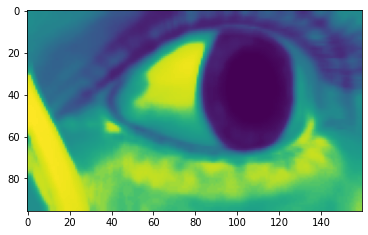

In [99]:
img = sample['img']
plt.imshow(img)
img = torch.from_numpy(img).to('cuda')[None, None]
print(img.shape)

In [100]:
gaze, heatmaps, landmarks_out = proj_a(img)

In [101]:
gaze, heatmaps, landmarks_out = gaze.cpu().numpy(), heatmaps.cpu().numpy(), landmarks_out.cpu().numpy()

(34, 48, 80)
(48, 80)


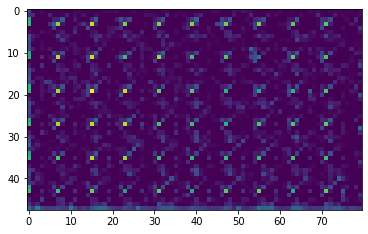

In [102]:
heatmaps = heatmaps[0]
print(heatmaps.shape)
merged_heatmaps = np.mean(heatmaps[16:33], axis=0)
print(merged_heatmaps.shape)
plt.imshow(heatmaps[1])

In [103]:
eye_img = sample['img']
land = landmarks_out[0] * np.array([96/48, 160/80])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[ 35.59792328 104.42045593]
hm [-0.04078522 -1.0191054 ]
(96, 160, 3)


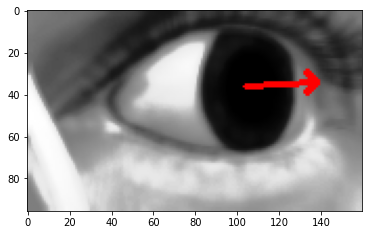

In [104]:
gaze = gaze[0]

print(land[-2])
y, x = land[-2]
eye_img = draw_gaze(eye_img, [x, y], gaze, color=(255, 0, 0))

print("hm", gaze)
print(eye_img.shape)
plt.imshow(eye_img)